# RQ4: Temporal emergence of AI discourse

This notebook analyses how AI discourse has emerged and intensified over time in Swedish parliamentary documents, comparing motioner (MP proposals) with propositioner (government bills) to identify which document type leads the discourse.

## Setup and imports

In [1]:
import re
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

# set visualisation style
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
sns.set_palette(['#9b59b6', '#e91e63'])

## Data loading and parsing

In [2]:
def parse_document(file_path):
    """extract metadata and clean text from a parliamentary document file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # split metadata from content
    parts = content.split('=' * 80, 1)
    if len(parts) != 2:
        return None
    
    metadata_text, html_content = parts
    
    # extract metadata fields
    metadata = {}
    for line in metadata_text.strip().split('\n'):
        if ':' in line:
            key, value = line.split(':', 1)
            metadata[key.strip().lower().replace(' ', '_')] = value.strip()
    
    # extract plain text from HTML
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator=' ', strip=True)
    
    # remove scanning disclaimers
    text = re.sub(r'Observera att dokumentet är inskannat.*?förekomma\.?', '', text, flags=re.IGNORECASE)
    
    return {
        'document_id': metadata.get('document_id', ''),
        'title': metadata.get('title', ''),
        'date': metadata.get('date', ''),
        'parliamentary_year': metadata.get('parliamentary_year', ''),
        'text': text.strip()
    }

In [3]:
# load motioner
mot_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/data/motioner')
mot_files = list(mot_dir.glob('*.txt'))

mot_data = []
for file_path in mot_files:
    doc = parse_document(file_path)
    if doc:
        doc['doc_type'] = 'mot'
        mot_data.append(doc)

print(f"Loaded {len(mot_data)} motioner")

Loaded 452 motioner


In [4]:
# load propositioner
prop_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/data/propositioner')
prop_files = list(prop_dir.glob('*.txt'))

prop_data = []
for file_path in prop_files:
    doc = parse_document(file_path)
    if doc:
        doc['doc_type'] = 'prop'
        prop_data.append(doc)

print(f"Loaded {len(prop_data)} propositioner")

Loaded 700 propositioner


In [5]:
# combine into single dataframe
df = pd.DataFrame(mot_data + prop_data)
print(f"Total documents: {len(df)}")
df.head()

Total documents: 1152


,document_id,title,date,parliamentary_year,text,doc_type
0,hd023729,Internationellt samarbete i en utmanande tid,2025-10-07,2025/26,Motion till riksdagen 2025/26:3729 av Kerstin ...,mot
1,hd023645,"Utgiftsområde 9 Hälsovård, sjukvård och social...",2025-10-07,2025/26,Motion till riksdagen 2025/26:3645 av Fredrik ...,mot
2,hc02351,Pornografi och sexuell exploatering på nätet,2024-09-24,2024/25,Motion till riksdagen 2024/25:351 av Ida Ekero...,mot
3,ha021483,Användning av moderna tester för prostatacancer,2022-11-22,2022/23,Motion till riksdagen 2022/23:1483 av Adnan Di...,mot
4,h5022531,Utgiftsområde 24 Näringsliv,2017-10-04,2017/18,Motion till riksdagen 2017/18:2531 av Josef Fr...,mot


## Temporal parsing and filtering

In [6]:
def extract_year(parliamentary_year):
    """extract primary year from parliamentary year format (e.g., '2023/24' -> 2023)."""
    if not parliamentary_year:
        return None
    match = re.match(r'(\d{4})', parliamentary_year)
    if match:
        return int(match.group(1))
    return None

df['year'] = df['parliamentary_year'].apply(extract_year)

# remove rows without valid year
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

print(f"Year range: {df['year'].min()} - {df['year'].max()}")
print(f"Documents with valid year: {len(df)}")

Year range: 1989 - 2025
Documents with valid year: 1152


In [7]:
# focus on 2010 onwards where AI discourse intensifies
df_filtered = df[df['year'] >= 2010].copy()
print(f"Documents from 2010 onwards: {len(df_filtered)}")
print(f"\nYear distribution:")
print(df_filtered['year'].value_counts().sort_index())

Documents from 2010 onwards: 945

Year distribution:
year
2010     24
2011     17
2012     18
2013     33
2014     20
2015     30
2016     26
2017     53
2018     45
2019     68
2020     78
2021    104
2022     69
2023    103
2024    132
2025    125
Name: count, dtype: int64


## AI mention analysis

In [8]:
def count_ai_mentions(text):
    """count occurrences of AI-related terms in text."""
    if not text:
        return 0
    
    text_lower = text.lower()
    patterns = [
        r'\bai\b',
        r'artificiell intelligens',
        r'maskininlärning',
        r'djupinlärning'
    ]
    
    total = 0
    for pattern in patterns:
        total += len(re.findall(pattern, text_lower))
    
    return total

def count_words(text):
    """count total words in text."""
    if not text:
        return 0
    return len(re.findall(r'\b\w+\b', text))

df_filtered['ai_mentions'] = df_filtered['text'].apply(count_ai_mentions)
df_filtered['word_count'] = df_filtered['text'].apply(count_words)
df_filtered['ai_density'] = (df_filtered['ai_mentions'] / df_filtered['word_count'] * 1000).round(2)

# handle division by zero
df_filtered['ai_density'] = df_filtered['ai_density'].replace([np.inf, -np.inf], 0)

print(f"Summary statistics:")
print(df_filtered[['ai_mentions', 'word_count', 'ai_density']].describe())

Summary statistics:
       ai_mentions    word_count  ai_density
count   945.000000  9.450000e+02  945.000000
mean      4.601058  4.924967e+04    2.230804
std      14.792226  8.991139e+04    7.107525
min       0.000000  1.370000e+02    0.000000
25%       0.000000  4.117000e+03    0.000000
50%       1.000000  1.755600e+04    0.090000
75%       4.000000  6.426000e+04    0.790000
max     333.000000  1.804505e+06   51.570000


## Document volume over time

In [9]:
# count documents per year by type
volume_by_year = df_filtered.groupby(['year', 'doc_type']).size().unstack(fill_value=0)
volume_by_year.head()

doc_type,mot,prop
year,,
2010,0,24
2011,1,16
2012,1,17
2013,0,33
2014,0,20


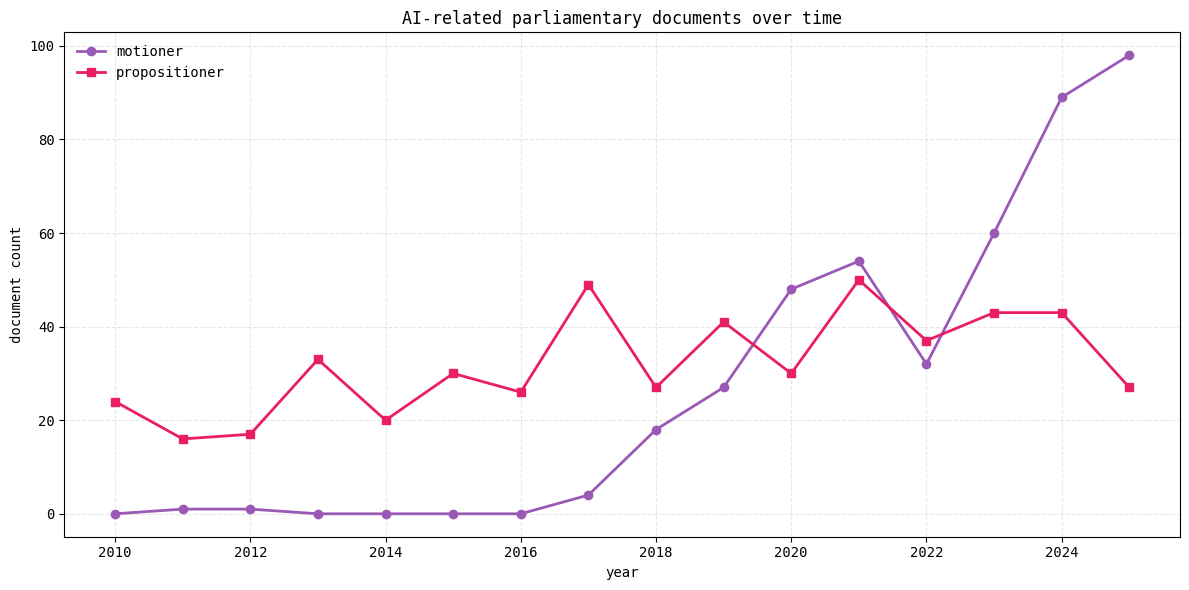

In [10]:
# visualise volume trends
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(volume_by_year.index, volume_by_year['mot'], 
        marker='o', linewidth=2, label='motioner', color='#9b59b6')
ax.plot(volume_by_year.index, volume_by_year['prop'], 
        marker='s', linewidth=2, label='propositioner', color='#e91e63')

ax.set_xlabel('year')
ax.set_ylabel('document count')
ax.set_title('AI-related parliamentary documents over time')
ax.legend(frameon=False)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [11]:
# calculate year-over-year growth rates
growth_rates = volume_by_year.pct_change() * 100
growth_rates = growth_rates.round(1)

print("Year-over-year growth rates (%):")
print(growth_rates)

Year-over-year growth rates (%):
doc_type    mot  prop
year                 
2010        NaN   NaN
2011        inf -33.3
2012        0.0   6.2
2013     -100.0  94.1
2014        NaN -39.4
2015        NaN  50.0
2016        NaN -13.3
2017        inf  88.5
2018      350.0 -44.9
2019       50.0  51.9
2020       77.8 -26.8
2021       12.5  66.7
2022      -40.7 -26.0
2023       87.5  16.2
2024       48.3   0.0
2025       10.1 -37.2


## Discourse intensity over time

In [12]:
# calculate mean AI mention density per year by type
intensity_by_year = df_filtered.groupby(['year', 'doc_type'])['ai_density'].mean().unstack()
intensity_by_year.head()

doc_type,mot,prop
year,,
2010,NaN,0.004583
2011,24.10,0.000000
2012,24.39,0.001765
2013,NaN,0.002121
2014,NaN,0.005500


Saved to /Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq4_intensity.png


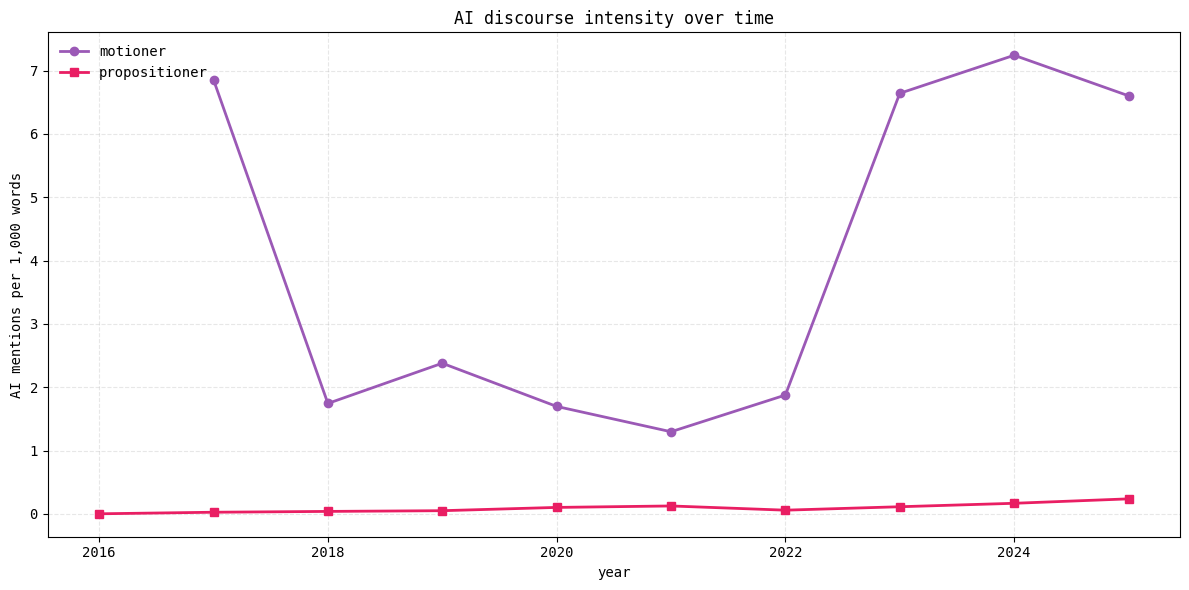

In [13]:
# visualise intensity trends (from 2016 onwards)
intensity_recent = intensity_by_year[intensity_by_year.index >= 2016]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(intensity_recent.index, intensity_recent['mot'], 
        marker='o', linewidth=2, label='motioner', color='#9b59b6')
ax.plot(intensity_recent.index, intensity_recent['prop'], 
        marker='s', linewidth=2, label='propositioner', color='#e91e63')

ax.set_xlabel('year')
ax.set_ylabel('AI mentions per 1,000 words')
ax.set_title('AI discourse intensity over time')
ax.legend(frameon=False)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()

# save to results
results_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results')
fig.savefig(results_dir / 'rq4_intensity.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"Saved to {results_dir / 'rq4_intensity.png'}")

plt.show()

## Cumulative document growth

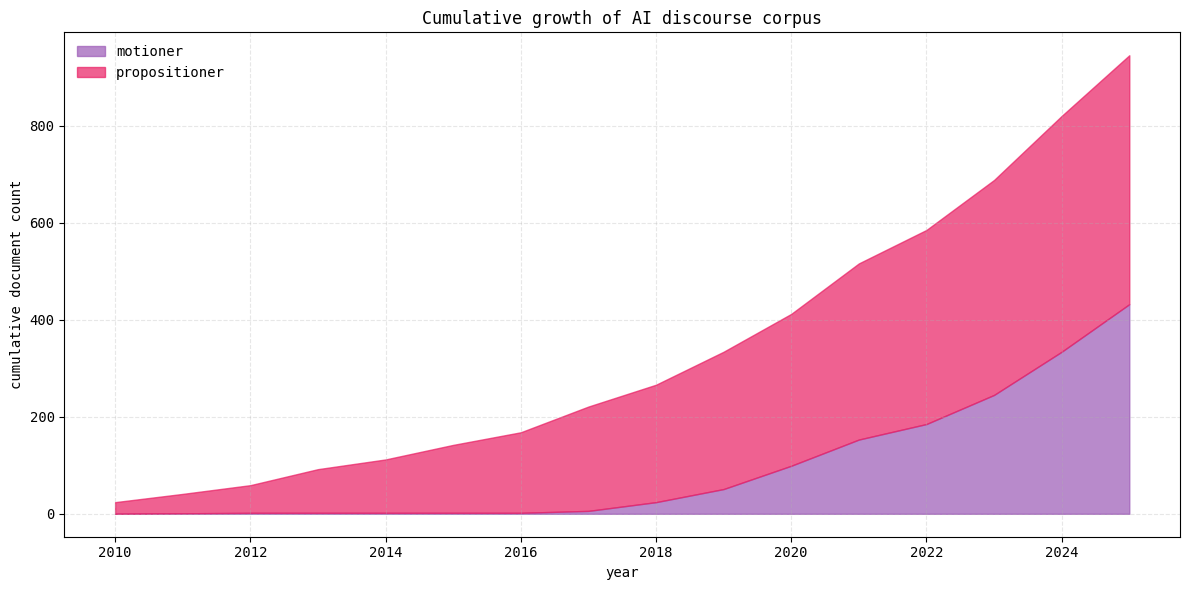

In [14]:
# calculate cumulative sums
cumulative_volume = volume_by_year.cumsum()

fig, ax = plt.subplots(figsize=(12, 6))

ax.fill_between(cumulative_volume.index, 0, cumulative_volume['mot'], 
                 alpha=0.7, label='motioner', color='#9b59b6')
ax.fill_between(cumulative_volume.index, cumulative_volume['mot'], 
                 cumulative_volume['mot'] + cumulative_volume['prop'],
                 alpha=0.7, label='propositioner', color='#e91e63')

ax.set_xlabel('year')
ax.set_ylabel('cumulative document count')
ax.set_title('Cumulative growth of AI discourse corpus')
ax.legend(frameon=False)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## Lead/lag analysis

In [15]:
# identify first occurrence of AI discourse by document type
first_mot = df_filtered[df_filtered['doc_type'] == 'mot']['year'].min()
first_prop = df_filtered[df_filtered['doc_type'] == 'prop']['year'].min()

print(f"First AI mention in motioner: {first_mot}")
print(f"First AI mention in propositioner: {first_prop}")
print(f"\nLead time: {abs(first_mot - first_prop)} years")

if first_mot < first_prop:
    print("Motioner lead the discourse")
elif first_prop < first_mot:
    print("Propositioner lead the discourse")
else:
    print("Both document types emerged simultaneously")

First AI mention in motioner: 2011
First AI mention in propositioner: 2010

Lead time: 1 years
Propositioner lead the discourse


In [16]:
# identify inflection points (year with highest growth rate)
print("\nInflection points (highest growth rates):")
print(f"\nMotioner peak growth: {growth_rates['mot'].idxmax()} ({growth_rates['mot'].max():.1f}%)")
print(f"Propositioner peak growth: {growth_rates['prop'].idxmax()} ({growth_rates['prop'].max():.1f}%)")


Inflection points (highest growth rates):

Motioner peak growth: 2011 (inf%)
Propositioner peak growth: 2013 (94.1%)


In [17]:
# calculate correlation between mot and prop trends
correlation = volume_by_year['mot'].corr(volume_by_year['prop'])
print(f"\nCorrelation between motioner and propositioner volume: {correlation:.3f}")

intensity_correlation = intensity_by_year['mot'].corr(intensity_by_year['prop'])
print(f"Correlation between motioner and propositioner intensity: {intensity_correlation:.3f}")


Correlation between motioner and propositioner volume: 0.434
Correlation between motioner and propositioner intensity: -0.436


## Annotated timeline with key events

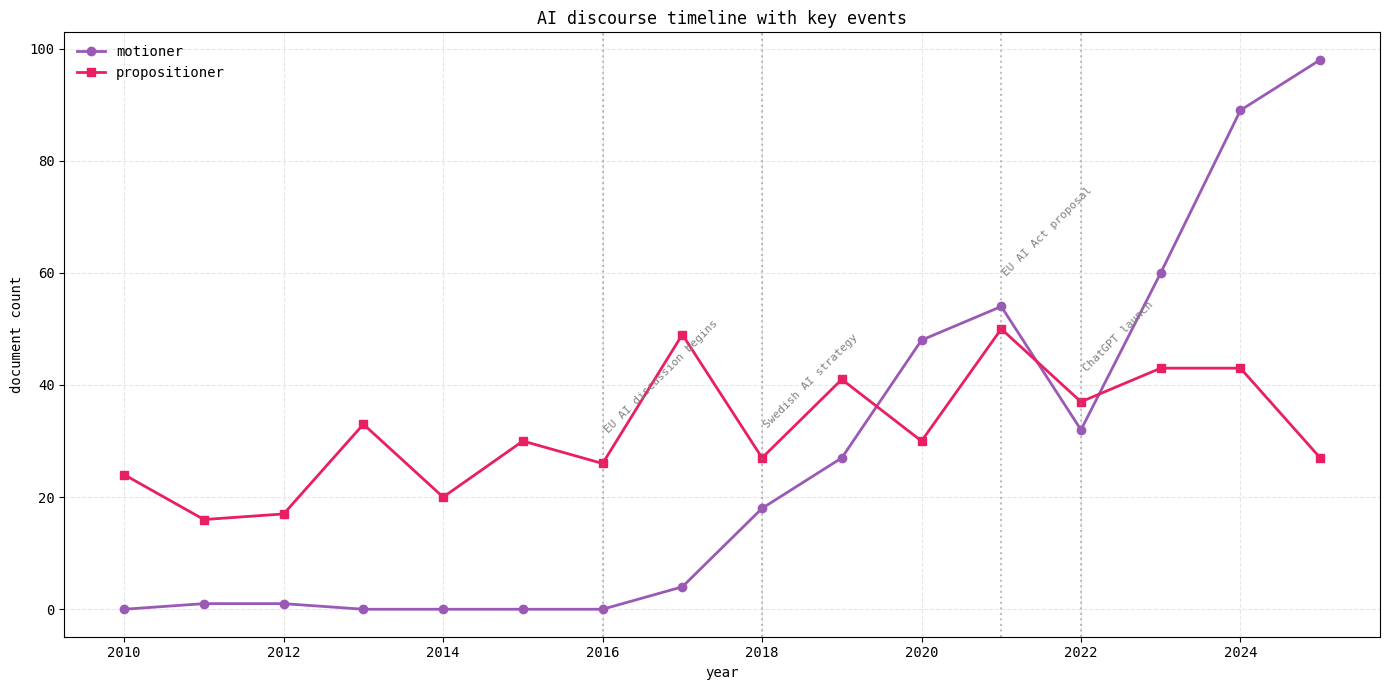

In [18]:
# create annotated timeline
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(volume_by_year.index, volume_by_year['mot'], 
        marker='o', linewidth=2, label='motioner', color='#9b59b6')
ax.plot(volume_by_year.index, volume_by_year['prop'], 
        marker='s', linewidth=2, label='propositioner', color='#e91e63')

# annotate key events
events = [
    (2016, 'EU AI discussion begins'),
    (2018, 'Swedish AI strategy'),
    (2021, 'EU AI Act proposal'),
    (2022, 'ChatGPT launch')
]

for year, event in events:
    if year in volume_by_year.index:
        y_max = max(volume_by_year.loc[year, 'mot'], volume_by_year.loc[year, 'prop'])
        ax.axvline(x=year, color='gray', linestyle=':', alpha=0.5)
        ax.text(year, y_max + 5, event, rotation=45, 
                ha='left', va='bottom', fontsize=8, color='gray')

ax.set_xlabel('year')
ax.set_ylabel('document count')
ax.set_title('AI discourse timeline with key events')
ax.legend(frameon=False)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## Statistical summary

In [19]:
# summarise key findings
summary = {
    'metric': [],
    'motioner': [],
    'propositioner': []
}

# total documents
summary['metric'].append('total_documents')
summary['motioner'].append(len(df_filtered[df_filtered['doc_type'] == 'mot']))
summary['propositioner'].append(len(df_filtered[df_filtered['doc_type'] == 'prop']))

# first appearance
summary['metric'].append('first_year')
summary['motioner'].append(first_mot)
summary['propositioner'].append(first_prop)

# peak year (by volume)
summary['metric'].append('peak_volume_year')
summary['motioner'].append(volume_by_year['mot'].idxmax())
summary['propositioner'].append(volume_by_year['prop'].idxmax())

# peak volume
summary['metric'].append('peak_volume_count')
summary['motioner'].append(volume_by_year['mot'].max())
summary['propositioner'].append(volume_by_year['prop'].max())

# mean intensity
summary['metric'].append('mean_ai_density')
summary['motioner'].append(df_filtered[df_filtered['doc_type'] == 'mot']['ai_density'].mean().round(2))
summary['propositioner'].append(df_filtered[df_filtered['doc_type'] == 'prop']['ai_density'].mean().round(2))

# average annual growth (excluding first year)
summary['metric'].append('avg_growth_rate_pct')
summary['motioner'].append(growth_rates['mot'][1:].mean().round(1))
summary['propositioner'].append(growth_rates['prop'][1:].mean().round(1))

summary_df = pd.DataFrame(summary)
print("Summary statistics:")
print(summary_df.to_string(index=False))

Summary statistics:
             metric  motioner  propositioner
    total_documents     432.0         513.00
         first_year    2011.0        2010.00
   peak_volume_year    2025.0        2021.00
  peak_volume_count      98.0          50.00
    mean_ai_density       4.8           0.07
avg_growth_rate_pct       inf          10.20


In [20]:
# identify breakthrough year (when cumulative docs exceed 50)
breakthrough_mot = cumulative_volume[cumulative_volume['mot'] >= 50].index.min()
breakthrough_prop = cumulative_volume[cumulative_volume['prop'] >= 50].index.min()

print(f"\nBreakthrough year (50+ cumulative documents):")
print(f"Motioner: {breakthrough_mot}")
print(f"Propositioner: {breakthrough_prop}")


Breakthrough year (50+ cumulative documents):
Motioner: 2019
Propositioner: 2012


## Export results

In [21]:
# prepare export data
export_data = []

for year in volume_by_year.index:
    export_data.append({
        'year': year,
        'mot_count': volume_by_year.loc[year, 'mot'],
        'prop_count': volume_by_year.loc[year, 'prop'],
        'mot_intensity': intensity_by_year.loc[year, 'mot'],
        'prop_intensity': intensity_by_year.loc[year, 'prop'],
        'mot_cumulative': cumulative_volume.loc[year, 'mot'],
        'prop_cumulative': cumulative_volume.loc[year, 'prop']
    })

export_df = pd.DataFrame(export_data)

# ensure results directory exists
results_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results')
results_dir.mkdir(parents=True, exist_ok=True)

# save to csv
output_path = results_dir / 'rq4_temporal_trends.csv'
export_df.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

Results saved to /Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq4_temporal_trends.csv
